## T5

The T5 model is a language model based on the Transformer architecture, developed by Google's research team. It introduces a "text-to-text" framework unifying various natural language processing tasks into a single format. This allows T5 to handle a wide range of tasks, including translation, summarization, question-answering, and classification, by transforming text inputs into corresponding outputs.

T5's strength lies in its ability to generalize across different tasks and domains achieving state-of-the-art performance in various benchmarks. Its effectiveness is attributed to large-scale training on extensive datasets, covering diverse languages and domains. The model is trained on a combination of supervised and unsupervised learning, using a unified objective function. This allows it to learn from unlabeled data, improving its performance on downstream tasks.

The model leverages a variant of the Transformer architecture, enabling it to effectively process long-range dependencies in text. The bidirectional information flow in its encoder-decoder architecture further enhances its capabilities during inference. T5's ability to handle complex linguistic structures, such as long sentences and paragraphs, makes it a powerful tool for natural language processing.

<center><img src = "markdown_files/t5.png"></center>

[Reference Link](https://arxiv.org/pdf/1910.10683.pdf)



In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt

from rouge import Rouge

from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [2]:
dataset = load_dataset('cnn_dailymail', '3.0.0')
data = dataset['test']
data_df = pd.DataFrame(data)

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
data_df['article_length'] = data_df['article'].apply(lambda x: len(x))

In [4]:
data_df['summary_length'] = data_df['article'].apply(lambda x: math.ceil(len(x)/10))

In [5]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

f:\University of Birmingham\Summer Project\aroha\venv\lib\site-packages\transformers\models\t5\tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
def get_summary(row):
    
    max_input_length = row['article_length']
    max_summary_length = row['summary_length']
    input_text = row['article']
    
    input_ids = tokenizer.encode(input_text, truncation=True, max_length=max_input_length, return_tensors="pt")
    
    summary_ids = model.generate(input_ids, max_length=max_summary_length)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

#### Apply summarization

In [ ]:
data_df['summary'] = data_df.apply(lambda row: get_summary(row), axis=1)

### Calculate ROUGE Scores

The **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) scores represent the evaluation metrics for summarization. ROUGE measures the similarity between the generated summary (system summary) and the reference summary (ground truth summary) in terms of overlapping n-grams.

The scores are reported as follows:

**ROUGE-1**: This metric focuses on the overlap of unigram (single word) sequences between the system summary and the reference summary. It measures the recall (r), precision (p), and F1 score (f) for unigrams.

**ROUGE-2**: This metric considers the overlap of bigram (two-word) sequences between the system summary and the reference summary. It measures the recall, precision, and F1 score for bigrams.

**ROUGE-L**: This metric calculates the longest common subsequence (LCS) between the system summary and the reference summary. It measures the recall, precision, and F1 score based on the LCS.


- **Precision**: Precision measures the accuracy or correctness of the generated summary. It is the ratio of the number of correctly identified relevant elements (such as words or n-grams) in the generated summary to the total number of identified elements. A higher precision indicates a lower rate of false positives.

- **Recall**: Recall measures the comprehensiveness or completeness of the generated summary. It is the ratio of the number of correctly identified relevant elements in the generated summary to the total number of relevant elements present in the reference summary. A higher recall indicates a lower rate of false negatives.

- **F1 score**: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that considers both precision and recall. The F1 score is calculated using the formula: F1 = 2 * (precision * recall) / (precision + recall). It ranges from 0 to 1, where a higher F1 score indicates a better balance between precision and recall.

In [ ]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

In [ ]:
data_df.to_csv('t5.csv.zip', index=False, compression='zip')

#### Calculate Average Recall, Precision, and F1 score for Rouge-1, Rouge-2 and Rouge-L

In [ ]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores.to_csv('t5_rouge.csv', index=True)

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.322569,0.126225,0.301622
precision,0.274918,0.095405,0.256285
f1-score,0.287994,0.104484,0.268916


#### Barplot for ROUGE scores

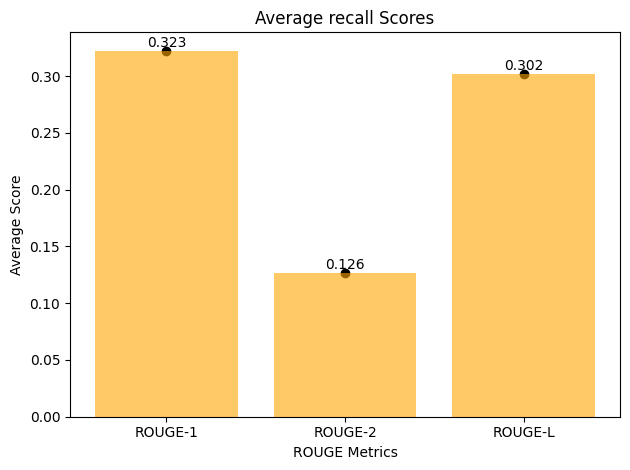

In [ ]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

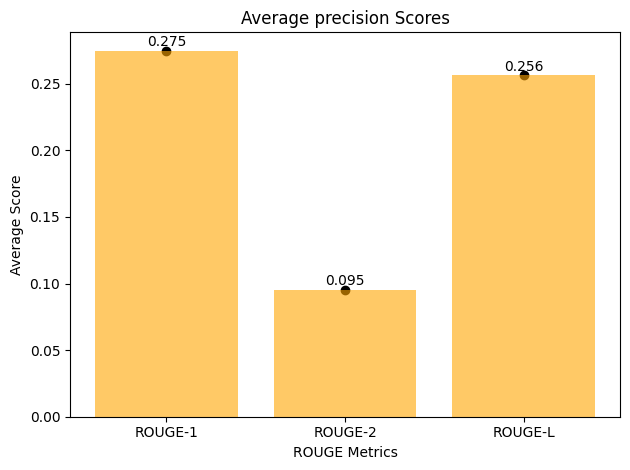

In [ ]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

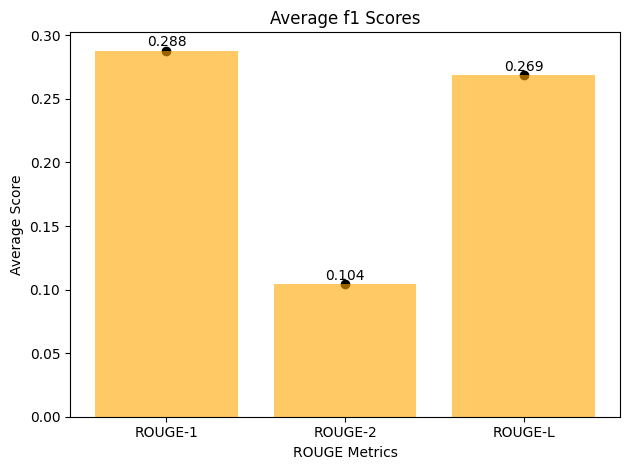

In [ ]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

#### Plot Heatmap for ROUGE scores

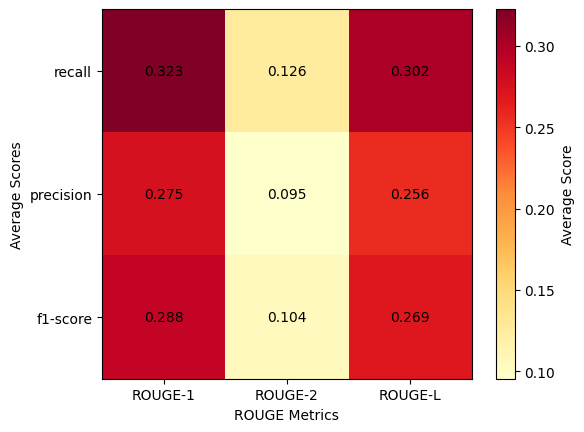

In [ ]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()